<a href="https://colab.research.google.com/github/GauravGhatuary/twitter-sentiment/blob/main/TwitterSentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
sns.set_palette('pastel')
sns.set_style('darkgrid')

In [ ]:
# Getting data from Kaggle
!pip install -q kaggle
from google.colab import files

files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gauravghatuary","key":"b53530207f2ae0166cdab1d99c8a18ac"}'}

In [ ]:
 mkdir ~/.kaggle

In [ ]:
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c tweet-sentiment-extraction

  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 88.4MB/s]


In [ ]:
!unzip tweet-sentiment-extraction.zip

Archive:  tweet-sentiment-extraction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# Reading data

In [ ]:
train_df=pd.read_csv('train.csv')
train_df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [ ]:
test_df=pd.read_csv('test.csv')
test_df

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive
...,...,...,...
3529,e5f0e6ef4b,"its at 3 am, im very tired but i can`t sleep ...",negative
3530,416863ce47,All alone in this old house again. Thanks for...,positive
3531,6332da480c,I know what you mean. My little dog is sinkin...,negative
3532,df1baec676,_sutra what is your next youtube video gonna b...,positive


In [ ]:
print(f'Shape of training data:{train_df.shape}')
print(f'Shape of test data:{test_df.shape}')

Shape of training data:(27481, 4)
Shape of test data:(3534, 3)


Training data has an extra 'selected text'column to capture the sentiment.



In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [ ]:
#Removing the null column
train_df=train_df.dropna(how='any',axis=0)

In [ ]:
train_df.shape

(27480, 4)

<Axes: xlabel='sentiment', ylabel='count'>

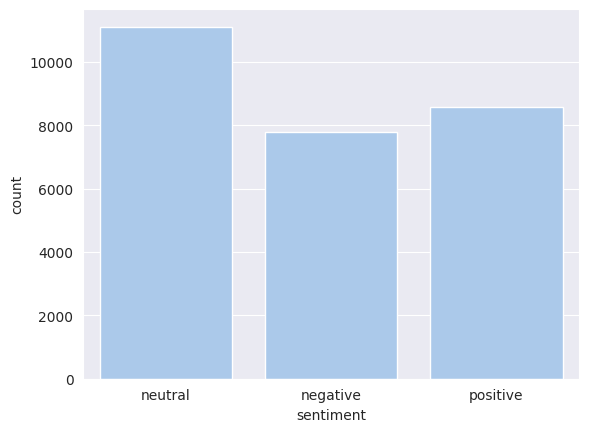

In [ ]:
sns.countplot(train_df,x='sentiment')

We can see that the dataframe is pretty much balanced

In Text processing, we need to represent the words as numeric vectors.

But first of all, we have to preprocess the input

# **Preprocessing Input**

In [ ]:
train_df['text'].head(5)

,text
0,"I`d have responded, if I were going"
1,Sooo SAD I will miss you here in San Diego!!!
2,my boss is bullying me...
3,what interview! leave me alone
4,"Sons of ****, why couldn`t they put them on t..."


Tweets are mostly casual mode which may also contain some phone nos,URLs and Hashtags.
We have to choose the tokenizer which best deals with these



In [ ]:
#Analyzing texts
for i in np.arange(1,20):
  print(train_df['text'][i])

 Sooo SAD I will miss you here in San Diego!!!
my boss is bullying me...
 what interview! leave me alone
 Sons of ****, why couldn`t they put them on the releases we already bought
http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth
2am feedings for the baby are fun when he is all smiles and coos
Soooo high
 Both of you
 Journey!? Wow... u just became cooler.  hehe... (is that possible!?)
 as much as i love to be hopeful, i reckon the chances are minimal =P i`m never gonna get my cake and stuff
I really really like the song Love Story by Taylor Swift
My Sharpie is running DANGERously low on ink
i want to go to music tonight but i lost my voice.
test test from the LG enV2
Uh oh, I am sunburned
 S`ok, trying to plot alternatives as we speak *sigh*
i`ve been sick for the past few days  and thus, my hair looks wierd.  if i didnt have a hat on it would look... http://tinyurl.com/mnf4kw
is back home now      gonna miss every one
Hes just not that into

In [ ]:
import string
import re

**Websites** beginning with https/www or **email** rarely convey meaning information, we will remove this with  regular expression

In [ ]:
pattern_web =  r"(([\w]+:)?//)?(([\d\w]|%[a-fA-F\d]{2,2})+(:([\d\w]|%[a-fA-f\d]{2,2})+)?@)?([\d\w][-\d\w]{0,253}[\d\w]\.)+[\w]{2,4}(:[\d]+)?(/([-+_~.\d\w]|%[a-fA-f\d]{2,2})*)*(\?(&?([-+_~.\d\w]|%[a-fA-f\d]{2,2})=?)*)?(#([-+_~.\d\w]|%[a-fA-f\d]{2,2})*)?"

In [ ]:
str='''Im going to http://www.example.com google.com https://example.co.uk'''
re.sub(pattern_web,'',str)

'Im going to   '

In [ ]:
pattern_email=r"(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*|(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*)@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])"

In [ ]:
str='''Send mail to user@example.com person-1992@fg.co.in manu@epl.co.uk'''
re.sub(pattern_email,' ',str)

'Send mail to      '

Tweets contain **hashtags** and **handles**
From hashtags, # should be removed leaving the base word
Handles should be removed as they are used to refer to someone

In [ ]:
pattern_hash=r'#(\w+)'

In [ ]:
str=''' I'm cool  #Summer2024 but my phone# # 444 Feat#UK '''
re.sub(pattern_hash," \\1",str)  #Keeps the part of expression removing hashtags only

" I'm cool   Summer2024 but my phone# # 444 Feat UK "

In [ ]:
pattern_handle=r'@\w+'  # Only matched if @ followed by alphanumeric characters & underscore

In [ ]:
str=''' @Mike Is ur email gg@hj.com '''
re.sub(pattern_handle," ",str)

'   Is ur email gg .com '

Twitter also contains **emojis** which can convey important informations, we will use emoji package to convert those into expressions

In [ ]:
!pip install emoji


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.2/553.2 kB 7.6 MB/s eta 0:00:00


In [ ]:
import emoji

In [ ]:
str='I love python 😊 '
emoji.demojize(str)

'I love python :smiling_face_with_smiling_eyes: '

Many tweets use **contractions** of full words and these must be expanded to reveal their meaning

In [ ]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 6.8 MB/s eta 0:00:00


In [ ]:
import contractions

In [ ]:
contractions.safety_keys

{"he'll",
 "he's",
 "i'd",
 "i'll",
 "it's",
 "o'",
 "we'd",
 "we'll",
 "we're",
 "who're"}

In [ ]:
str="I`d have responded, if I were going"
contractions.fix(str)

'I`d have responded, if I were going'

Often in tweets, some **characters are repeated** no of times to accentuate their meaning, for eg way to waaaay etc.
For this , we will contract the repeated characters

In [ ]:
pattern_repeat=r'([A-Za-z])\1{2,}'  # Usage of #1 implies that 1st character used has to match.{2,}-repeat more than 2 times


In [ ]:
str=''' U r so greaat,lets be friendssss cool '''
re.sub(pattern_repeat,r'\1',str)

' U r so greaat,lets be friends cool '

Now that we have partially pre-processed tweets, there are still some processing that needs to be done:
1.**Numbers**: They reveal important information,but since we are basically classifying sentiment , their impact will be minimum.**Numbers will be removed**

2.**Proper Nouns & lower casing**: It will be very helpful if we can separate the proper nouns from Uppercase letters , but in tweets Upper case apperas all over the place due to casual nature.Morever, in sentiment analysis, proper nouns dont reveal much info**All letters to be lowercased**

3.**Punctuation**: Mostly used ungramatically, and since we have already taken care of contractions,handles and hashtags,their retention will be confusing.**Remaining punctuations should be removed**


In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
pattern_num=r'[0-9]'

In [ ]:
re.sub(pattern_num," ","i've 4 $ %")

"i've   $ %"

In [ ]:
#Defing a function to apply all pre-processing steps

def pre_process(tweet):
  t_mod=re.sub(pattern_web,'',tweet)        #Removing URLs
  t_mod=re.sub(pattern_email,' ',t_mod)     #Removing email
  t_mod=re.sub(pattern_hash," \\1",t_mod)   #Removing '#'
  t_mod=re.sub(pattern_handle," ",t_mod)    #Removing handles
  t_mod=emoji.demojize(t_mod)               #De-emojifying

  pattern_apos=r'`'                         #Replacing ` with ' to be used in contraction
  t_mod=re.sub(pattern_apos,"'",t_mod)


  t_mod=contractions.fix(t_mod)              #Removing contractions

  t_mod=re.sub(pattern_repeat,r'\1',t_mod)   #Normalising repeated characters

  pattern_num=r'[0-9]'
  t_mod=re.sub(pattern_num," ",t_mod)       #Removing numbers

  pattern_punc="[" + re.escape(string.punctuation) + "]"       #Removing punctuation
  t_mod=re.sub(pattern_punc," ",t_mod)

  t_mod=t_mod.lower()                       #lowering characters

  pattern_space=r'\s+'                      #Removing extra white space chars
  t_mod=re.sub(pattern_space," ",t_mod)

  return t_mod


In [ ]:
train_df['cleaned_text']=train_df['text'].apply(pre_process)

<ipython-input-39-ae8d039363e9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['cleaned_text']=train_df['text'].apply(pre_process)


In [ ]:
train_df

,textID,text,selected_text,sentiment,cleaned_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,i would have responded if i were going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,so sad i will miss you here in san diego
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons of why could not they put them on the re...
...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,wish we could come see you on denver husband ...
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,i have wondered about rake to the client has ...
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,yay good for both of you enjoy the break you ...
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,but it was worth it


# Tokenizing

In [ ]:
from nltk.tokenize import TreebankWordTokenizer

In [ ]:
tokenizer=TreebankWordTokenizer()

In [ ]:
train_df['tokens']=train_df['cleaned_text'].apply(lambda x:tokenizer.tokenize(x))

<ipython-input-43-f2aedd072694>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['tokens']=train_df['cleaned_text'].apply(lambda x:tokenizer.tokenize(x))


In [ ]:
train_df

,textID,text,selected_text,sentiment,cleaned_text,tokens
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,i would have responded if i were going,"[i, would, have, responded, if, i, were, going]"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,so sad i will miss you here in san diego,"[so, sad, i, will, miss, you, here, in, san, d..."
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me,"[my, boss, is, bullying, me]"
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview leave me alone,"[what, interview, leave, me, alone]"
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons of why could not they put them on the re...,"[sons, of, why, could, not, they, put, them, o..."
...,...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,wish we could come see you on denver husband ...,"[wish, we, could, come, see, you, on, denver, ..."
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,i have wondered about rake to the client has ...,"[i, have, wondered, about, rake, to, the, clie..."
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,yay good for both of you enjoy the break you ...,"[yay, good, for, both, of, you, enjoy, the, br..."
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,but it was worth it,"[but, it, was, worth, it]"


<ipython-input-46-f57eb8ee5421>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['token_len']=train_df['tokens'].apply(lambda x:len(x))


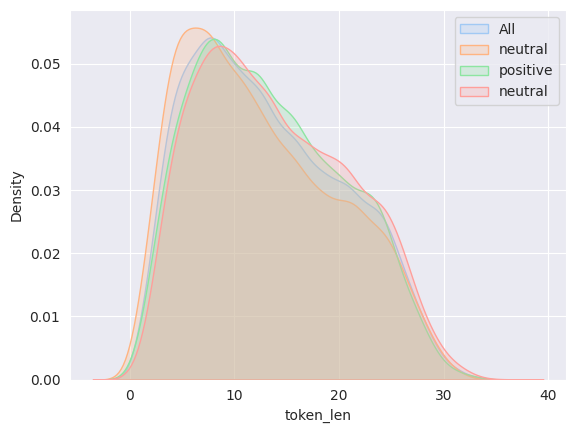

In [ ]:
#Checking the length  of tokens
train_df['token_len']=train_df['tokens'].apply(lambda x:len(x))


sns.kdeplot(train_df,x='token_len',legend='All',fill=True,label='All')
sns.kdeplot(train_df[train_df['sentiment']=='neutral'],x='token_len',label='neutral',fill=True)
sns.kdeplot(train_df[train_df['sentiment']=='positive'],x='token_len',label='positive',fill=True)
sns.kdeplot(train_df[train_df['sentiment']=='negative'],x='token_len',label='neutral',fill=True)
plt.legend()
plt.show()

We can see that there is no notable difference in distribution of token length among sentiments, though'Neutral sentiment' seems to be of smaller length

In [ ]:
from collections import Counter

In [ ]:

ct=Counter()
for token_list in train_df['tokens']:
  ct.update(token_list)


In [ ]:
sum(list(ct.values()))

362681

In [ ]:
#Most common words in tweets
dict(ct.most_common(50))

{'i': 17681,
 'to': 10979,
 'the': 9124,
 'a': 6819,
 'you': 6641,
 'is': 6639,
 'not': 6101,
 'my': 5549,
 'it': 5424,
 'and': 5170,
 'am': 4115,
 'in': 3818,
 'for': 3658,
 'have': 3297,
 'of': 3284,
 'that': 3170,
 'me': 2877,
 'on': 2875,
 'so': 2870,
 'do': 2446,
 'but': 2406,
 'are': 2309,
 'just': 2277,
 'day': 2166,
 'with': 2098,
 'be': 2023,
 'was': 1980,
 'at': 1901,
 'can': 1876,
 'will': 1860,
 'all': 1685,
 'now': 1595,
 'good': 1579,
 'this': 1572,
 'going': 1569,
 'out': 1523,
 'up': 1508,
 's': 1455,
 'no': 1447,
 'get': 1434,
 'like': 1353,
 'go': 1286,
 'got': 1248,
 'love': 1207,
 'your': 1170,
 'today': 1155,
 'work': 1152,
 'too': 1127,
 'what': 1085,
 'we': 1039}

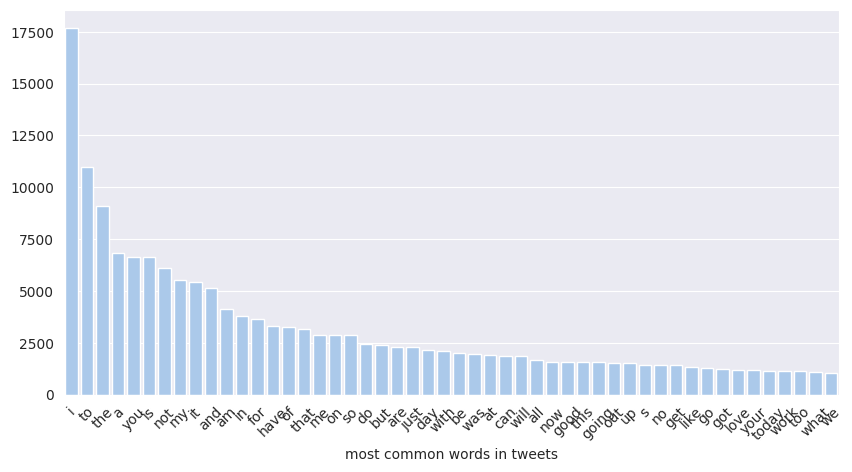

In [ ]:
#Distribution of 50 most common tokens
plt.figure(figsize=(10,5))
sns.barplot(x=dict(ct.most_common(50)).keys(),y=dict(ct.most_common(50)).values())
plt.xticks(rotation=45)
plt.xlabel('most common words in tweets')
plt.show()

We can see that the most common words are the general words, which though important in context, will be useful for differentiating between sentiments

We will **filter out all the common words in english dict**

In [ ]:
from nltk.corpus import stopwords

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stopword_list=stopwords.words('english')

In [ ]:
train_df['tokens_wo_stopwords']=train_df['tokens'].apply(lambda x:[i for i in x if i not in stopword_list])

<ipython-input-55-99be6416626e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['tokens_wo_stopwords']=train_df['tokens'].apply(lambda x:[i for i in x if i not in stopword_list])


In [ ]:
train_df

,textID,text,selected_text,sentiment,cleaned_text,tokens,token_len,tokens_wo_stopwords
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,i would have responded if i were going,"[i, would, have, responded, if, i, were, going]",8,"[would, responded, going]"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,so sad i will miss you here in san diego,"[so, sad, i, will, miss, you, here, in, san, d...",10,"[sad, miss, san, diego]"
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me,"[my, boss, is, bullying, me]",5,"[boss, bullying]"
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview leave me alone,"[what, interview, leave, me, alone]",5,"[interview, leave, alone]"
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons of why could not they put them on the re...,"[sons, of, why, could, not, they, put, them, o...",14,"[sons, could, put, releases, already, bought]"
...,...,...,...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,wish we could come see you on denver husband ...,"[wish, we, could, come, see, you, on, denver, ...",17,"[wish, could, come, see, denver, husband, lost..."
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,i have wondered about rake to the client has ...,"[i, have, wondered, about, rake, to, the, clie...",25,"[wondered, rake, client, made, clear, net, for..."
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,yay good for both of you enjoy the break you ...,"[yay, good, for, both, of, you, enjoy, the, br...",21,"[yay, good, enjoy, break, probably, need, hect..."
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,but it was worth it,"[but, it, was, worth, it]",5,[worth]


Using **lemmatization** for identifying the root words

In [ ]:
from nltk.stem import WordNetLemmatizer


In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
lemmatizer.lemmatize('gives')

'give'

In [ ]:
train_df['tokens_lemma']=train_df['tokens_wo_stopwords'].apply(lambda x:[lemmatizer.lemmatize(i) for i in x])
train_df['tokens_lemma']

<ipython-input-61-ebd1d6b5b072>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['tokens_lemma']=train_df['tokens_wo_stopwords'].apply(lambda x:[lemmatizer.lemmatize(i) for i in x])


,tokens_lemma
0,"[would, responded, going]"
1,"[sad, miss, san, diego]"
2,"[bos, bullying]"
3,"[interview, leave, alone]"
4,"[son, could, put, release, already, bought]"
...,...
27476,"[wish, could, come, see, denver, husband, lost..."
27477,"[wondered, rake, client, made, clear, net, for..."
27478,"[yay, good, enjoy, break, probably, need, hect..."
27479,[worth]


In [ ]:
#Counters for listing tokens

ct_all=Counter()
ct_neutral=Counter()
ct_positive=Counter()
ct_negative=Counter()

for token_list in train_df['tokens_lemma']:
  ct_all.update(token_list)

for token_list in train_df[train_df['sentiment']=='neutral']['tokens_lemma']:
  ct_neutral.update(token_list)

for token_list in train_df[train_df['sentiment']=='positive']['tokens_lemma']:
  ct_positive.update(token_list)

for token_list in train_df[train_df['sentiment']=='negative']['tokens_lemma']:
  ct_negative.update(token_list)


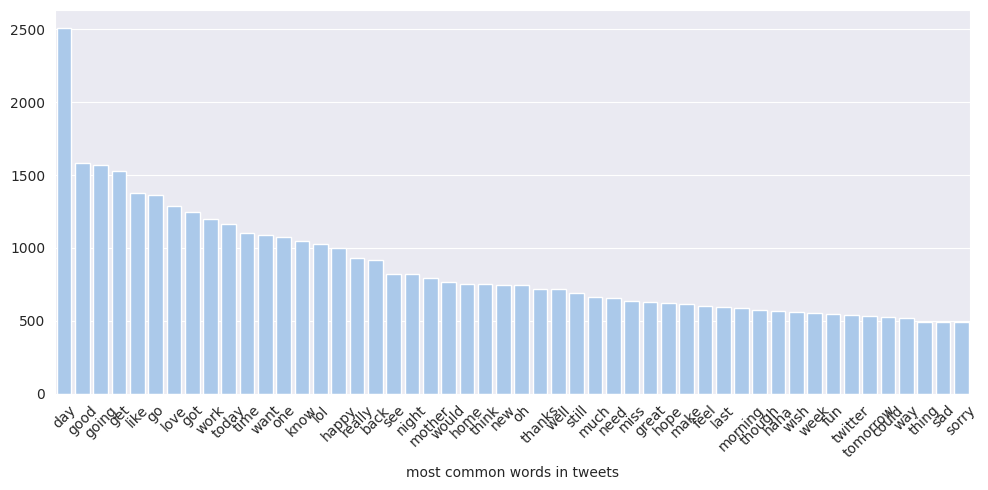

In [ ]:
#Distribution of 50 most common tokens
plt.figure(figsize=(10,5))
sns.barplot(x=dict(ct_all.most_common(50)).keys(),y=dict(ct_all.most_common(50)).values())
plt.xticks(rotation=45)
plt.xlabel('most common words in tweets')
plt.tight_layout()
plt.show()

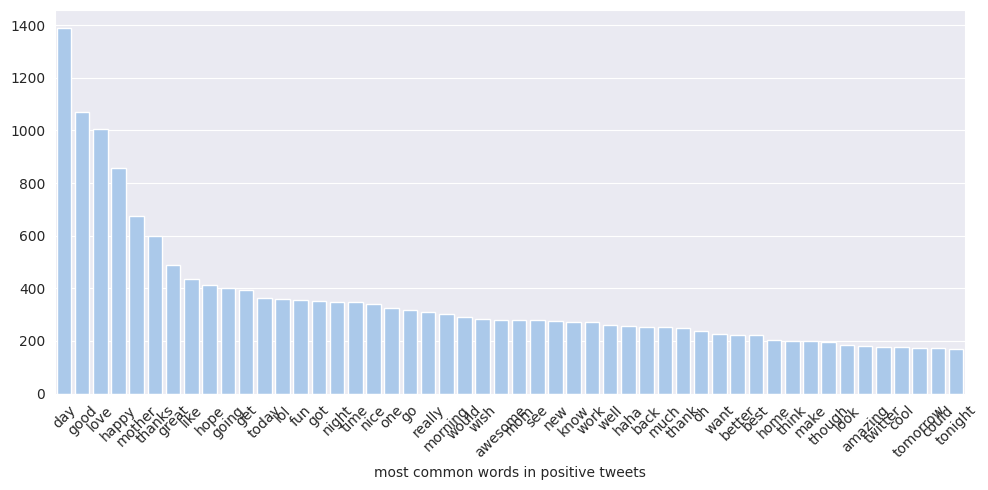

In [ ]:
#Distribution of 50 most common positive tokens
plt.figure(figsize=(10,5))
sns.barplot(x=dict(ct_positive.most_common(50)).keys(),y=dict(ct_positive.most_common(50)).values())
plt.xticks(rotation=45)
plt.xlabel('most common words in positive tweets')
plt.tight_layout()
plt.show()

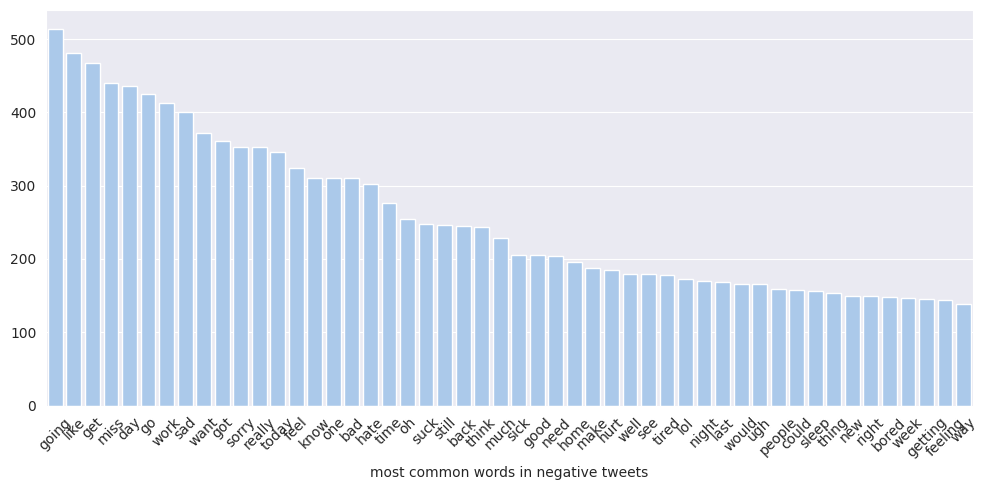

In [ ]:
#Distribution of 50 most common negative tokens
plt.figure(figsize=(10,5))
sns.barplot(x=dict(ct_negative.most_common(50)).keys(),y=dict(ct_negative.most_common(50)).values())
plt.xticks(rotation=45)
plt.xlabel('most common words in negative tweets')
plt.tight_layout()
plt.show()

In [ ]:
!pip install wordcloud

In [ ]:
from wordcloud import WordCloud

In [ ]:
def generate_wordcloud(list_,label_list):
  plt.figure(figsize=(10,20))
  k=1
  for i in list_:
    plt.subplot(len(list_),1,k)
    word_cloud=WordCloud()
    word_cloud.generate_from_frequencies(i)
    plt.imshow(word_cloud)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(label_list[k-1])
    k+=1


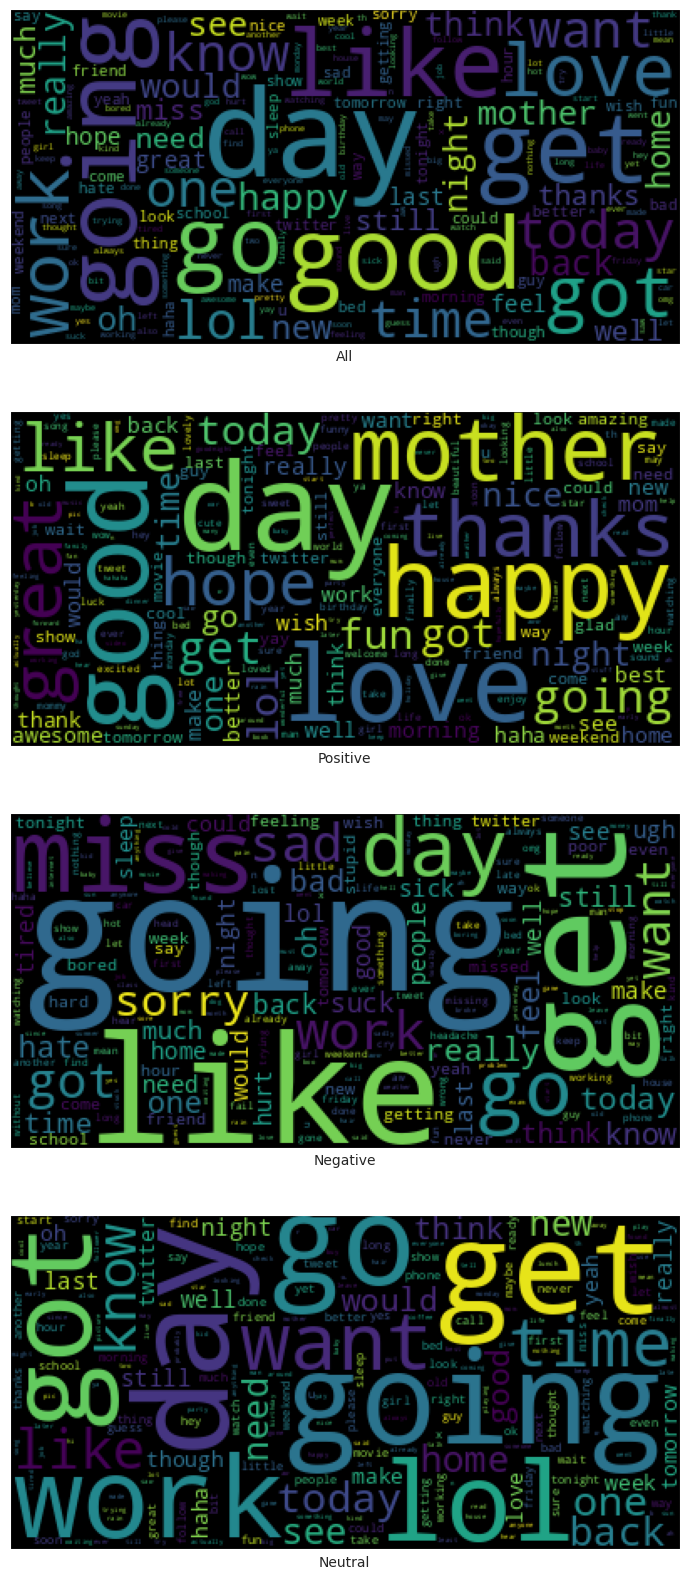

In [ ]:
generate_wordcloud([ct_all,ct_positive,ct_negative,ct_neutral],['All','Positive','Negative','Neutral'])

Now that we have visualized the tokens , we need to convert our tokens into numeric vectors.

There are several ways to convert but we will use word embeddings to get the most feature-rich representation of our tokens

Further we will use the original token list for maximum representation of our data

In [ ]:
#Getting the final data
train_df_chosen=train_df[['tokens','sentiment']]
train_df_chosen

,tokens,sentiment
0,"[i, would, have, responded, if, i, were, going]",neutral
1,"[so, sad, i, will, miss, you, here, in, san, d...",negative
2,"[my, boss, is, bullying, me]",negative
3,"[what, interview, leave, me, alone]",negative
4,"[sons, of, why, could, not, they, put, them, o...",negative
...,...,...
27476,"[wish, we, could, come, see, you, on, denver, ...",negative
27477,"[i, have, wondered, about, rake, to, the, clie...",negative
27478,"[yay, good, for, both, of, you, enjoy, the, br...",positive
27479,"[but, it, was, worth, it]",positive


In [ ]:
#Converting target class to on-hot vector
train_df_final=pd.get_dummies(train_df_chosen,columns=['sentiment'],dtype='int')

train_df_final['sentence']=train_df_final['tokens'].apply(lambda x:" ".join(x))   #Converting tokens back to string to process in Vectorizer
train_df_final

,tokens,sentiment_negative,sentiment_neutral,sentiment_positive,sentence
0,"[i, would, have, responded, if, i, were, going]",0,1,0,i would have responded if i were going
1,"[so, sad, i, will, miss, you, here, in, san, d...",1,0,0,so sad i will miss you here in san diego
2,"[my, boss, is, bullying, me]",1,0,0,my boss is bullying me
3,"[what, interview, leave, me, alone]",1,0,0,what interview leave me alone
4,"[sons, of, why, could, not, they, put, them, o...",1,0,0,sons of why could not they put them on the rel...
...,...,...,...,...,...
27476,"[wish, we, could, come, see, you, on, denver, ...",1,0,0,wish we could come see you on denver husband l...
27477,"[i, have, wondered, about, rake, to, the, clie...",1,0,0,i have wondered about rake to the client has m...
27478,"[yay, good, for, both, of, you, enjoy, the, br...",0,0,1,yay good for both of you enjoy the break you p...
27479,"[but, it, was, worth, it]",0,0,1,but it was worth it


In [ ]:
#Getting the test dataset
test_df

,textID,text,sentiment,cleaned_text,tokens
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,last session of the day,"[last, session, of, the, day]"
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,shanghai is also really exciting precisely sk...,"[shanghai, is, also, really, exciting, precise..."
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,recession hit veronique branquinho she has to ...,"[recession, hit, veronique, branquinho, she, h..."
3,01082688c6,happy bday!,positive,happy birthday,"[happy, birthday]"
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,i like it,"[i, like, it]"
...,...,...,...,...,...
3529,e5f0e6ef4b,"its at 3 am, im very tired but i can`t sleep ...",negative,its at am i am very tired but i cannot sleep b...,"[its, at, am, i, am, very, tired, but, i, can,..."
3530,416863ce47,All alone in this old house again. Thanks for...,positive,all alone in this old house again thanks for t...,"[all, alone, in, this, old, house, again, than..."
3531,6332da480c,I know what you mean. My little dog is sinkin...,negative,i know what you mean my little dog is sinking...,"[i, know, what, you, mean, my, little, dog, is..."
3532,df1baec676,_sutra what is your next youtube video gonna b...,positive,sutra what is your next youtube video going t...,"[sutra, what, is, your, next, youtube, video, ..."


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


In [ ]:
#Pre-processing and tokenizing
test_df['cleaned_text']=test_df['text'].apply(pre_process)        #Applying pre-processing

test_df['tokens']=test_df['cleaned_text'].apply(lambda x:tokenizer.tokenize(x))   #Applying tokenizer


In [ ]:
test_df_chosen=test_df[['tokens','sentiment']]
test_df_final=pd.get_dummies(test_df_chosen,columns=['sentiment'],dtype='int')

test_df_final['sentence']=test_df_final['tokens'].apply(lambda x:" ".join(x))
test_df_final

,tokens,sentiment_negative,sentiment_neutral,sentiment_positive,sentence
0,"[last, session, of, the, day]",0,1,0,last session of the day
1,"[shanghai, is, also, really, exciting, precise...",0,0,1,shanghai is also really exciting precisely sky...
2,"[recession, hit, veronique, branquinho, she, h...",1,0,0,recession hit veronique branquinho she has to ...
3,"[happy, birthday]",0,0,1,happy birthday
4,"[i, like, it]",0,0,1,i like it
...,...,...,...,...,...
3529,"[its, at, am, i, am, very, tired, but, i, can,...",1,0,0,its at am i am very tired but i can not sleep ...
3530,"[all, alone, in, this, old, house, again, than...",0,0,1,all alone in this old house again thanks for t...
3531,"[i, know, what, you, mean, my, little, dog, is...",1,0,0,i know what you mean my little dog is sinking ...
3532,"[sutra, what, is, your, next, youtube, video, ...",0,0,1,sutra what is your next youtube video going to...


In [ ]:
train_df_features=train_df_final['sentence']
train_df_targets=train_df_final.drop(['sentence','tokens'],axis=1)

test_df_features=test_df_final['sentence']
test_df_targets=test_df_final.drop(['sentence','tokens'],axis=1)

In [ ]:
#Splitting into train and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val=train_test_split(train_df_features,train_df_targets,random_state=42,shuffle=True,test_size=0.2)

In [ ]:
X_test=test_df_features
y_test=test_df_targets

In [ ]:
#Checking shape of our dataset
print(f"Shape of X train:{X_train.shape}")
print(f"Shape of X val:{X_val.shape}")
print(f"Shape of Y train:{y_train.shape}")
print(f"Shape of Y val:{y_val.shape}")

Shape of X train:(21984,)
Shape of X val:(5496,)
Shape of Y train:(21984, 3)
Shape of Y val:(5496, 3)


# Vectorizing

In [ ]:
from tensorflow import keras
from keras.layers import TextVectorization


In [ ]:
#Running  a counter to list all tokens
ct=Counter()
for token_list in train_df_final['tokens']:
  ct.update(token_list)

In [ ]:
print(f'No of tokens present in our vocabulary:{len(ct)}')
max_tokens=len(ct)

No of tokens present in our vocabulary:22520


In [ ]:
token_list=list(sorted(ct.keys()))

In [ ]:
text_vectorization = TextVectorization(max_tokens,output_mode="int",output_sequence_length=30) #Limiting sequence length to 30

In [ ]:
#Adapting the vocabulary
text_vectorization.adapt(token_list)

In [ ]:
text_vectorization.vocabulary_size()

22520

In [ ]:
X_train_vector=text_vectorization(X_train)
X_train_vector

<tf.Tensor: shape=(21984, 30), dtype=int64, numpy=
array([[ 8723, 13712, 12521, ...,     0,     0,     0],
       [ 2896, 15182,  2148, ...,     0,     0,     0],
       [22225,  4930, 21410, ...,     0,     0,     0],
       ...,
       [15436, 21862,  1581, ...,     0,     0,     0],
       [    1, 15182, 16425, ...,     0,     0,     0],
       [18821, 10879,  2873, ...,     0,     0,     0]])>

In [ ]:
X_val_vector=text_vectorization(X_val)
X_test_vector=text_vectorization(X_test)

Now that we have our dataset ready, we will apply gloVe vectorization for the tokens

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2024-10-02 12:42:05--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-10-02 12:42:05--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-10-02 12:42:05--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
#Using glove 100-D model

with open('glove.6B.100d.txt','r') as f:
  print(f.readline())



the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062



We can see structure of the file, we will parse separately the key and the values

In [ ]:
embeddings_index = {}
with open('glove.6B.100d.txt') as f:

  for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, "f", sep=" ")
    embeddings_index[word] = coefs

In [ ]:
feature_dim=100

In [ ]:
print(f'Length of word index dict:{len(embeddings_index)}')

Length of word index dict:400000


Now creating an Embedding Matrix based on the words present in our tokens

In [ ]:
embedding_matrix=np.zeros((max_tokens,feature_dim))

In [ ]:
for i,k in enumerate(text_vectorization.get_vocabulary()):
  print(f"{i} {k}")


Streaming output truncated to the last 5000 lines.
17520 decline
17521 decleration
17522 declaring
17523 declare
17524 decking
17525 decker
17526 deck
17527 decisive
17528 decisions
17529 decision
17530 deciding
17531 decides
17532 decidedly
17533 decided
17534 decide
17535 decently
17536 decent
17537 decemberists
17538 december
17539 deceiving
17540 deceitful
17541 deccy
17542 decal
17543 decaf
17544 decades
17545 decade
17546 dec
17547 debut
17548 debussy
17549 debugging
17550 debt
17551 deborah
17552 debit
17553 debian
17554 debby
17555 debbie
17556 debating
17557 debate
17558 deb
17559 deathstar
17560 deaths
17561 deathmatch
17562 deathfic
17563 deathcab
17564 death
17565 deary
17566 dearly
17567 dearie
17568 dear
17569 deanna
17570 deangeloredman
17571 dean
17572 dealz
17573 deals
17574 dealing
17575 dealin
17576 dealership
17577 dealer
17578 deal
17579 deakin
17580 deaf
17581 deadset
17582 deadpool
17583 deadly
17584 deadlines
17585 deadline
17586 deadliestcatch
17587 deadgirl
17

In [ ]:

for i,word in enumerate(text_vectorization.get_vocabulary()):
  embedding_vector=embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i,:]=embedding_vector



In [ ]:
print(f'Shape of embedding matrix={embedding_matrix.shape}')

Shape of embedding matrix=(22520, 100)


In [ ]:
null_arrays=np.sum((np.any(embedding_matrix,axis=1)==0))
null_arrays

889

We can see that there are 889 null arrays in our matrices which means that 889 of our words did not have corresponding glove vectors

# Training the model

In [ ]:
from keras.layers import Embedding,Dense,Dropout,Input,BatchNormalization,LSTM,Bidirectional

In [ ]:
LSTM?

For the embedding layer, trainable to be kept False to fix the weights and zero mask to be enabled to skip the zero occurence while using Bideirectional RNN

In [ ]:
#Defining Embedding layer
embedding=Embedding(input_dim=max_tokens,output_dim=feature_dim,embeddings_initializer=keras.initializers.Constant(embedding_matrix),trainable=False,mask_zero=True)

Using Bidirectional LSTM for model

In [ ]:
inputs=Input(shape=(30,))
embedded=embedding(inputs)
x=Bidirectional(LSTM(64,return_sequences=True))(embedded)
x=Bidirectional(LSTM(64))(x)
outputs=Dense(3,activation='softmax')(x)

model=keras.Model(inputs,outputs)

model.compile(optimizer='nadam',loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 30)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 30, 100)        │      2,252,000 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_4 (NotEqual)    │ (None, 30)             │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 30, 128)        │         84,480 │ embedding[4][0],       │
│ (Bidirectional)           │                        │                │ not_equal_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 128)            │         98,816 │ bidirectional_3[0][0], │
│ (Bidirectional)           │                        │                │ not_equal_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 3)              │            387 │ bidirectional_4[0][0]  │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,435,683 (9.29 MB)

 Trainable params: 183,683 (717.51 KB)

 Non-trainable params: 2,252,000 (8.59 MB)

In [ ]:
callback=keras.callbacks.ModelCheckpoint("Twitter_sentiment.keras",save_best_only=True)

In [ ]:
model.fit(X_train_vector,np.array(y_train), validation_data=[X_val_vector,np.array(y_val)], epochs=10,batch_size=64)

Epoch 1/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 91s 234ms/step - accuracy: 0.5614 - loss: 0.9215 - val_accuracy: 0.6559 - val_loss: 0.7727
Epoch 2/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 75s 218ms/step - accuracy: 0.6882 - loss: 0.7271 - val_accuracy: 0.6812 - val_loss: 0.7213
Epoch 3/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 74s 216ms/step - accuracy: 0.7214 - loss: 0.6661 - val_accuracy: 0.7011 - val_loss: 0.6917
Epoch 4/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 87s 231ms/step - accuracy: 0.7348 - loss: 0.6278 - val_accuracy: 0.7105 - val_loss: 0.6797
Epoch 5/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 77s 216ms/step - accuracy: 0.7492 - loss: 0.5969 - val_accuracy: 0.7087 - val_loss: 0.6883
Epoch 6/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 90s 238ms/step - accuracy: 0.7705 - loss: 0.5573 - val_accuracy: 0.7194 - val_loss: 0.6851
Epoch 7/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 82s 237ms/step - accuracy: 0.7869 - loss: 0.5229 - val_accuracy: 0.7234 - val_loss: 0.6846
Epoch 8/10
344/344 ━━━━━━━━━━━━━━━━━━━━ 76s 219ms/step - accuracy: 0.8046 - loss: 0

In [ ]:
model.evaluate(X_test_vector,np.array(y_test))

111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.7308 - loss: 0.7000


[0.7176694869995117, 0.7260894179344177]

In [ ]:
#saving the model
from google.colab import drive
drive.mount('/gdrive')

model.save('/gdrive/My Drive/Colab Notebooks/Twitter Sentiment/Twitter_sentiment.keras')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
y_test_prob=model.predict(X_test_vector)

111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step


In [ ]:
y_test_pred=np.argmax(y_test_prob,axis=1)
y_test_pred

array([1, 2, 0, ..., 0, 2, 2])

In [ ]:
y_test_org=np.argmax(y_test,axis=1)

In [ ]:
from sklearn import metrics

In [ ]:
print(f'Accuracy:{metrics.accuracy_score(y_test_org,y_test_pred)}')
print(f'Recall:{metrics.recall_score(y_test_org,y_test_pred,average="weighted")}')
print(f'Precision:{metrics.precision_score(y_test_org,y_test_pred,average="weighted")}')
print(f'F1-Score:{metrics.f1_score(y_test_org,y_test_pred,average="weighted")}')

Accuracy:0.7260894170911149
Recall:0.7260894170911149
Precision:0.726665543849101
F1-Score:0.7259914084132802


In [ ]:
print(metrics.classification_report(y_test_org,y_test_pred))

              precision    recall  f1-score   support

           0       0.72      0.67      0.70      1001
           1       0.69      0.72      0.70      1430
           2       0.78      0.79      0.78      1103

    accuracy                           0.73      3534
   macro avg       0.73      0.73      0.73      3534
weighted avg       0.73      0.73      0.73      3534



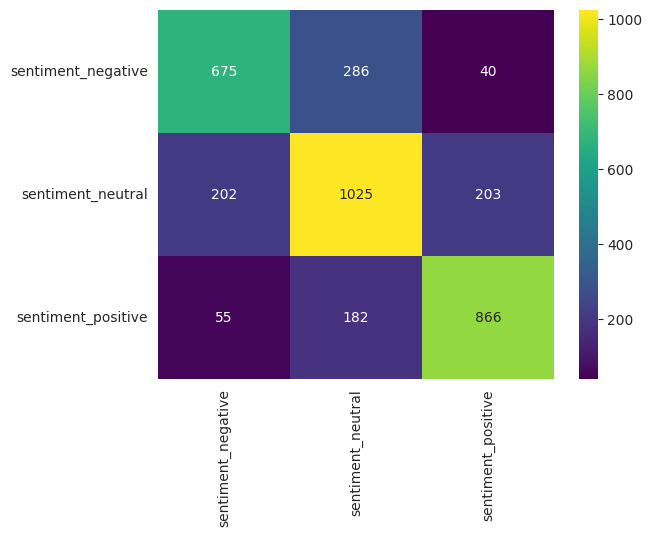

In [ ]:
conf_matrix=metrics.confusion_matrix(y_test_org,y_test_pred)
sns.heatmap(conf_matrix,cmap='viridis',annot=True,fmt='.0f',xticklabels=test_df_targets.columns, yticklabels=test_df_targets.columns)

plt.show()

Finally, we can see that we have received an accuracy of around 0.7 on Test Data,
but most of the mis-classifications has been recored for neutral tweets or have been misclassified as neutral

There are very few positive and negative tweets which have been misclassified as the opposite